# Import Function

In [1]:
import sys
sys.path.append('/mnt/glusterfs/notebook-repo/zipeng.lin/AUTOML/')

In [2]:
from import_packages import *
from tools import *
from sample_exploration import get_od_label
from data_aggregation import *
from data_cleaning import DataFilter, plot_missingno
from sample_exploration import get_pos_rate,desc_stat,feats_coverage_stat,sample_coverage_stat
from sample_splitter import sample_splitter
from feature_transformation import FeatureTransformer
from feature_trimming import FeatureTrimmer
from feature_scaling import FeatureScaler
from feature_encoding import FeatureEncoder
from feature_imputation import FeatureImputer
from feature_selection import FeatureFilter
from feature_evaluation import get_vif_cor, plot_hist_all, plot_joint_dist_all
from model_training import BAYESIAN_OPTIMIZATION, cv_check, xgbt, model_toolkit, model_selection
from model_evaluation import plot_all_figures
from recoding_statement import GenerateOutputFiles


/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Import Data

In [3]:
path = "/mnt/glusterfs/notebook-repo/zipeng.lin/AUTOML/data/maimaiche_data.csv"


## Import Data

In [4]:
df = df_ori = pd.read_csv(path, encoding='utf-8', sep='	')
del df['Unnamed: 0']
df = df[df.label != -1]
df.head()

#--------------------------------------------------------------------------------------------------#
"""
data cleaning
"""


,name,mobile,docid,create_date,audit_info_id,riskScore,max_delay_date,max_cur_term,loan_date,delay_over_30,gzt_is_reject,td_final_score,td_final_decision,baidu_risk_blacklevel,agentr_blacklist,umeng_credit_score,umeng_device_price,umeng_device_score,umeng_device_os,umeng_device_rank,umeng_id_score,umeng_interest_score,umeng_location_score,umeng_app_score,tj_yys_audit_info_id,yys_v2Flag_name,yys_fakeCallNum,yys_monthlyAvgConsume,yys_AveMonthlyConsume,yys_specialCate3CallNum,yys_specialCate3CalledNum,yys_specialCate3CalledSeconds,yys_specialCate2CallNum,yys_specialCate2CalledNum,yys_specialCate2CalledSeconds,yys_specialCate5CallNum,yys_specialCate5CalledNum,yys_specialCate5CalledSeconds,yys_specialCate7TalkNum,yys_specialCate6TalkNum,yys_specialCate13TalkNum,yys_specialCate15TalkNum,yys_specialCate16TalkNum,yys_specialCate4CallNum,yys_specialCate4CalledNum,yys_specialCate4CalledSeconds,yys_friendMap,yys_friendMap_2,yys_phoneLocation,geo_A3_RSL,geo_A4_RSL,geo_B7_RSL,rn,label
0,万志金,15039778057,413024198009031011,2018-05-10,66584,-3.0,0,6,2018-05-24,0,0.0,18,Accept,NaN,{},547.0,5.0,656.0,ios,0.0,510.0,566.0,578.0,535.0,SO1805108095361,万志金,0.0,166.84,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,NaN,NaN,NaN,1.0,8.0,1455.0,河南,NaN,河南,"\3\""""","\0\""""","\0\""""",1,0
1,于涛,13766822258,230404198009040524,2018-06-13,93949,-2.0,0,4,2018-07-02,0,0.0,6,Accept,NaN,{},577.0,3.0,681.0,android,0.0,532.0,611.0,588.0,535.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"\3\""""","\0\""""","\0\""""",1,0
3,代相龙,18226512799,340621196704077138,2018-07-08,117326,-3.0,0,4,2018-07-12,0,0.0,0,Accept,NaN,{},572.0,NaN,504.0,android,3.0,778.0,525.0,671.0,537.0,SO1807088112140,代相龙,0.0,119.88,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,NaN,5.0,1.0,95.0,安徽,NaN,安徽,"\3\""""","\0\""""","\0\""""",1,0
5,何坤,15107743398,450481198712200634,2018-05-30,82665,0.0,28,5,2018-06-10,1,0.0,12,Accept,NaN,{},-1.0,NaN,NaN,NaN,NaN,510.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"\1\""""","\0\""""","\0\""""",1,1
6,刘卫华,15732442111,132622196211231212,2018-05-04,59719,0.0,2,5,2018-05-31,0,0.0,6,Accept,NaN,{},-1.0,NaN,NaN,NaN,NaN,467.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"\1\""""","\0\""""","\0\""""",1,0


'\ndata cleaning\n'

# Global Definition

这个示例执行的是风控场景下的二分类

In [5]:
# Column of labels for model training（表示模型标签的列）
label = 'label'

#--------------------------------------------------------------------------------------------------#
# Column of datetimes（表示时间戳的列）
dt_col = 'loan_date'

#--------------------------------------------------------------------------------------------------#
# Column of unique ids（表示UID的列）
uid = 'docid'

#--------------------------------------------------------------------------------------------------#
# Columns need to be excluded from feature engineering and model training（不参与特征工程和模型训练的列）
exclude_list = [] + \
               [dt_col] + [uid]

#--------------------------------------------------------------------------------------------------#
# For risk managememnt model only（风控模型特有的选项）
# column of overdue days（表示逾期天数的列）
od_col = 'max_delay_date'

# columns of boolean targets for data exploration if exists（表示是否逾期（0/1/3/7/...天）的列）
# target = ['d0', 'd1', 'd3', 'd7']
target = ['label']

# set boolean targets if none is given（生成是否逾期（0/1/3/7/...天）的列）
if len(set(target) - set(df.columns)) != 0: #生成target（默认为d0、d1、d3、d7
    df = get_od_label(df, OD_TARGET=OD_TARGET, col=od_col, drop=False, event=1)
    
#--------------------------------------------------------------------------------------------------#
# use lR model or not（是否使用LR模型）
model_linear = True

# whether transform, trim, scale, woe-encode and impute features（是否执行特征转换、修剪、标准化、WOE编码、填补）
useTransformr = False
useTrimmr = False
useScalr = False
useWoeEncoder = True
useImputr = True

if model_linear: # （如果是逻辑回归模型，都做）
    useTransformr = True
    useTrimmr = True
    useScalr = True
    useWoeEncoder = True
    useImputr = True

#--------------------------------------------------------------------------------------------------#
useIvFiltr = True # （是否通过Information Value进行特征筛选）
useXgbfiFiltr = True # （是否通过XGB模型的特征重要性进行特征筛选）
useRFfiFiltr = True # （是否通过随机森林模型的特征重要性进行特征筛选）
useLRFiltr = True # （是否使用逻辑回归模型逐步回归法进行特征筛选）
useCorVifFiltr = True # （是否使用相关系数和膨胀系数进行特征筛选）

xgb_feat_cnt = 25 #（XGB模型的特征筛选留下增益和权重排名各自排名前xgb_feat_cnt的和合集）
rf_feat_cnt = 22 #（随机森林模型的特征筛选留下rf_feat_cnt个特征）
lr_feat_cnt = 18 #（逻辑回归逐步回归留下lr_feat_cnt个特征）

#--------------------------------------------------------------------------------------------------#
# define output files' name（定义输出文件的文件名）
model_name = 'Sample_Model'

ud_recoding_file = 'Feature_Recoding_Statement_for_ud_%s.txt'%model_name # （自定义特征工程的python可执行代码）
lr_recoding_file = 'Feature_Recoding_Statement_for_lr_%s.txt'%model_name # （逻辑回归标准特征工程的python可执行代码）
woe_recoding_stat_file = 'Feature_Woe_Recoding_Statistics_for_%s.xlsx'%model_name # （WOE编码的统计数据）
feature_stat_file = 'Feature_Statistical_Summary_for_%s.xlsx'%model_name # （样本的统计数据）
lr_model_equation_file = 'Equation_for_LR_%s.txt'%model_name # （逻辑回归方程）
lr_model_summary_file = 'Summary_for_LR_%s.xlsx'%model_name # （逻辑回归模型总结）


# AUTO ML

## DATA CLEANING

Figure 1: A matrix visualization of the nullity of the given DataFrame
Figure 2: A bar chart visualization of the nullity of the given DataFrame
Figure 3: Presents a 'seaborn' heatmap visualization of nullity correlation in the given DataFrame


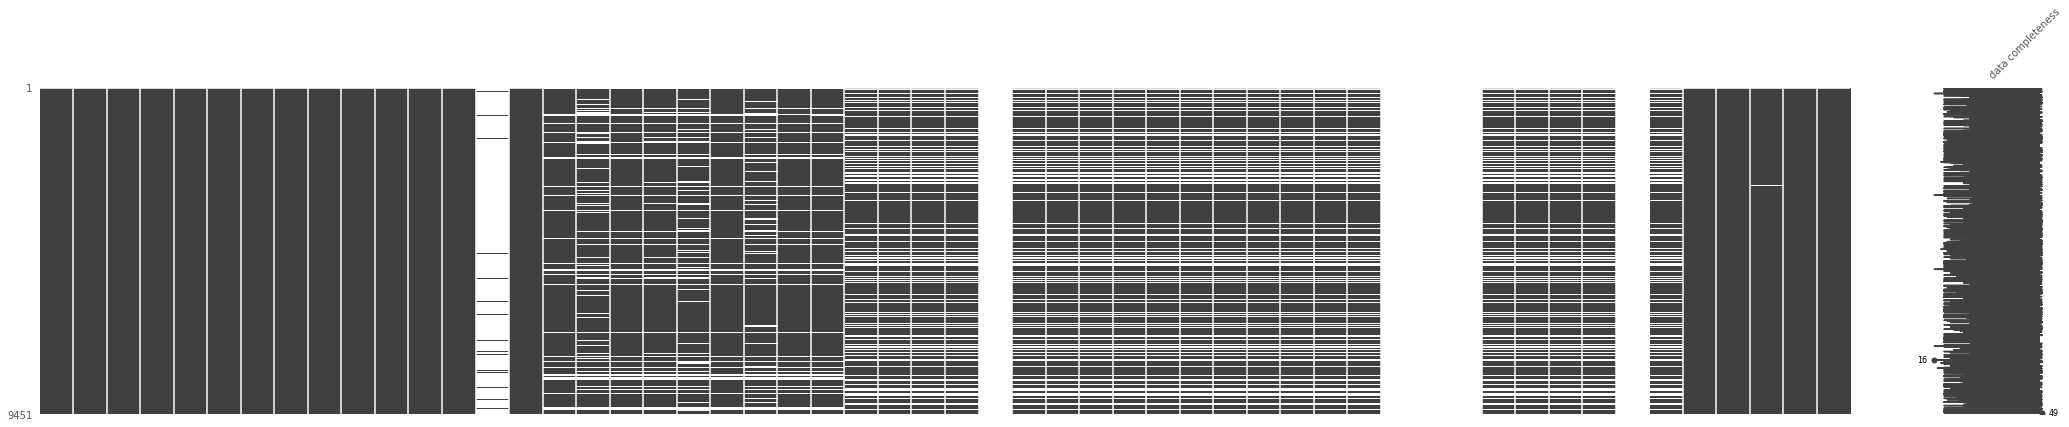

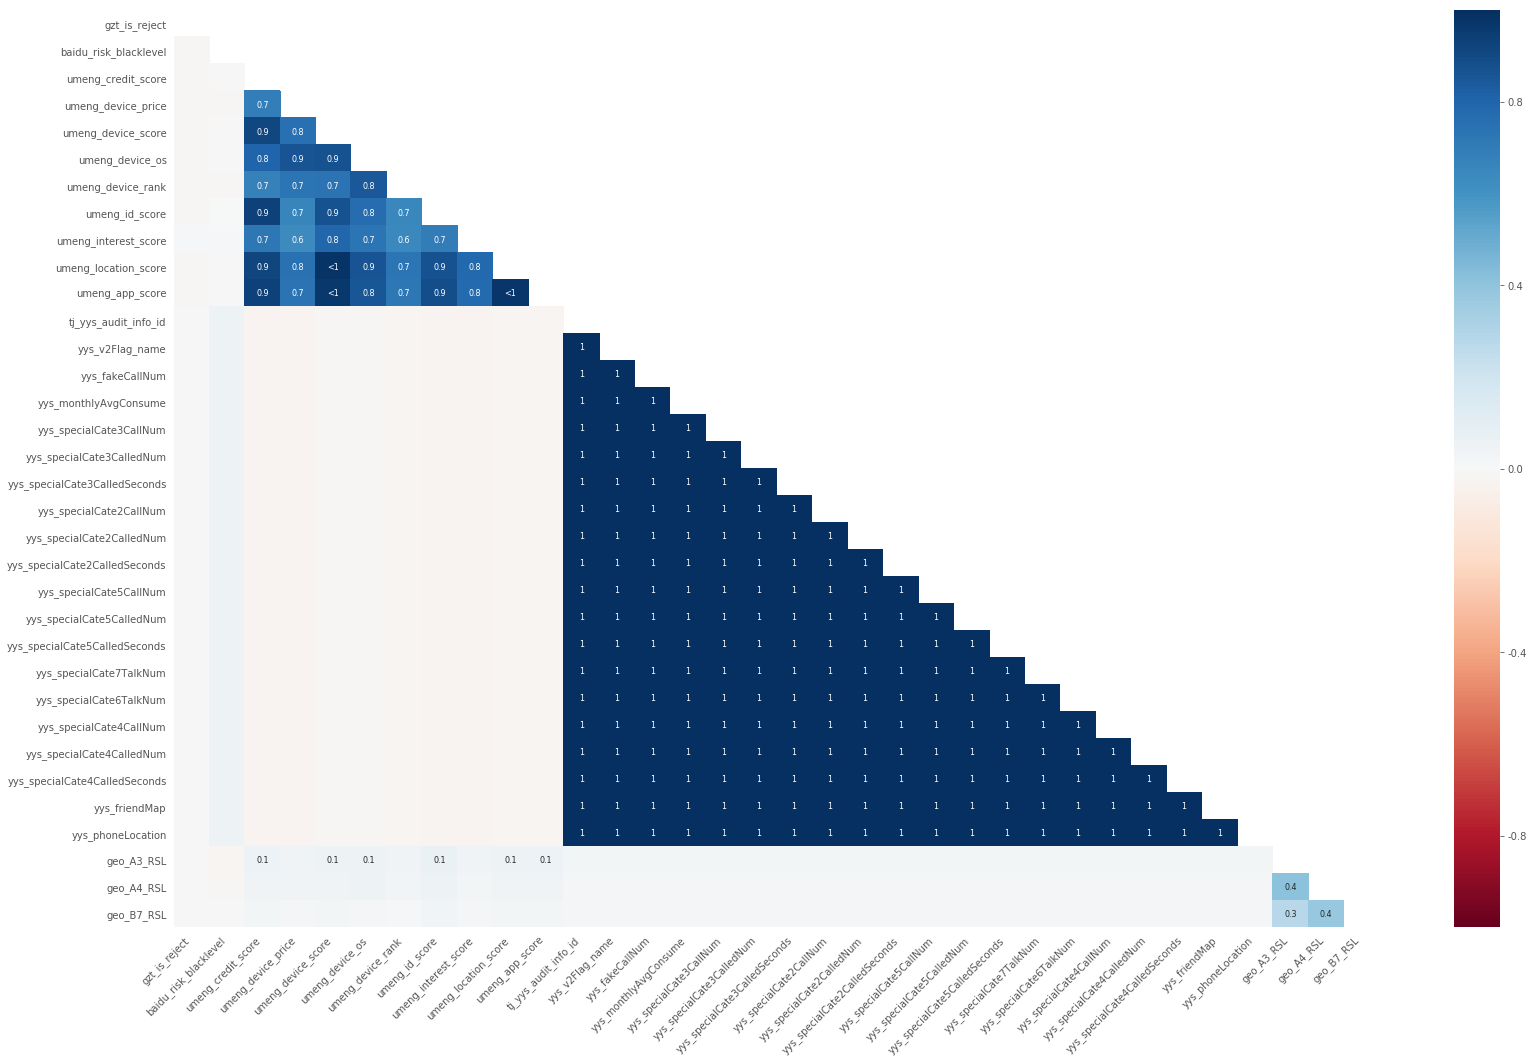

In [6]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################    1. DATA CLEANING    ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Visualize missing-value statistics（缺失值探索）
#--------------------------------------------------------------------------------------------------#
plot_missingno(df)


In [7]:
# Filter columns with number of unique values below defined threshold. Filter columns with missing rates
# above defined threshold. Filter columns with a value of high frequency above defined threshold
# （删除单一值过少（nunique_thr）、缺失值过高（missing_rate_thr）和高频值频率过高（HF_value_thr）的列，再手工剔除一些列）
#--------------------------------------------------------------------------------------------------#
filtr = DataFilter(nunique_thr=2, missing_rate_thr=0.99, HF_value_thr=0.98, silent=False,
                   exclude_list=['name', 'mobile', 'create_date', 'audit_info_id', 'tj_yys_audit_info_id',
                                 'yys_v2Flag_name', 'max_cur_term', 'max_delay_date', 'delay_over_30'])
#--------------------------------------------------------------------------------------------------#
df = filtr.fit_transform(df)


Statistics of columns to be dropped 

                          unique_value_cnt missing_rate  HF_value_pct
yys_specialCate13TalkNum                 0      100.00%           NaN
yys_specialCate15TalkNum                 0      100.00%           NaN
yys_AveMonthlyConsume                    0      100.00%           NaN
rn                                       1        0.00%      1.000000
gzt_is_reject                            1        0.05%      0.999471
yys_specialCate16TalkNum                 0      100.00%           NaN
yys_friendMap_2                          0      100.00%           NaN
yys_specialCate13TalkNum                 0      100.00%           NaN
yys_specialCate15TalkNum                 0      100.00%           NaN
yys_AveMonthlyConsume                    0      100.00%           NaN
yys_specialCate16TalkNum                 0      100.00%           NaN
yys_friendMap_2                          0      100.00%           NaN
rn                                       1        0.

## DATA AGGREGATION

In [8]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################  2. DATA AGGREGATION   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Apply RFM rule to do feature engineering where samples are aggregated by defined aggregate keys 
# and limitted by defined time spans in combinations
# （特征聚合）


## SAMPLE EXPLORATION

In [9]:
####################################################################################################
####################################################################################################
######################################                        ######################################
###################################### 3. SAMPLE EXPLORATION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# 1.Calculate positive rate (dependent variable's ratio of being positive)
# 2.Generate each feature's descriptive statistical summary, including missing count, missing rate, coverage count, coverage rate, 
#   unique values count, high-frequency value, high-frequency value's count, high-frequency value's probability of occurrence
# 3.Calculate positive rate of samples covered and uncovered by each feature
# 4.Calculate fully or partially covered sample and totally uncovered sample's positive rate
#--------------------------------------------------------------------------------------------------#
dr = get_pos_rate(df, target=target, is_ratio_pct=True, silent=False, event=1) # （标签正值率）
dcp_stat = desc_stat(df, target=target, is_ratio_pct=True, use_formater=True, silent=False);dcp_stat.head() # （特征统计数据）
fc_stat = feats_coverage_stat(df, target=target, is_ratio_pct=True, sort_value=True, silent=False, event=1) # （特征覆盖率统数据）
# sc_stat = sample_coverage_stat(df, target=target, exclude_col=[], silent=False, event=1)


Calculate each target's positive rate (dependent variable's ratio of being positive)

               label
positive_rate  20.8%

________________________________________________________________________________________________________________________ 

Generate descriptive statistical summary, including missing count, missing rate, 
 coverage count, coverage rate, unique values count, high-frequency value, high-frequency value's count, high-frequency value's
 probability of occurrence

________________________________________________________________________________________________________________________ 



,count,mean,std,min,1%,25%,50%,75%,99%,max,missing_cnt,missing_rate,coverage_count,coverage_rate,unique_value_cnt,HF_value,HF_value_cnt,HF_value_pct
yys_specialCate3CalledSeconds,6745,93.97,460.83,0.00,0.00,0.00,0.00,0.00,2009.08,11599.00,2706,28.63%,6745,71.37%,619,0,5475,57.93%
yys_specialCate5CalledSeconds,6745,107.46,791.43,0.00,0.00,0.00,0.00,0.00,2053.28,37542.00,2706,28.63%,6745,71.37%,621,0,5314,56.23%
yys_specialCate4CalledSeconds,6745,2998.58,7095.92,0.00,0.00,120.00,657.00,2672.00,33368.12,198710.00,2706,28.63%,6745,71.37%,3287,0,804,8.51%
riskScore,9451,-1.00,1.97,-3.00,-3.00,-2.00,-2.00,0.00,5.00,10.00,0,0.00%,9451,100.00%,23,-2,2813,29.76%
yys_specialCate5CallNum,6745,1.28,11.55,0.00,0.00,0.00,0.00,0.00,21.00,574.00,2706,28.63%,6745,71.37%,67,0,5584,59.08%


Calculate positive rate of samples covered and uncovered by each feature

                                         label
geo_B7_RSL                    UNCOVERED  32.3%
baidu_risk_blacklevel         COVERED    29.1%
yys_specialCate3CallNum       UNCOVERED  27.5%
yys_specialCate5CalledNum     UNCOVERED  27.5%
yys_specialCate5CallNum       UNCOVERED  27.5%
yys_specialCate3CalledSeconds UNCOVERED  27.5%
yys_specialCate6TalkNum       UNCOVERED  27.5%
yys_specialCate3CalledNum     UNCOVERED  27.5%
yys_specialCate2CalledSeconds UNCOVERED  27.5%
yys_specialCate2CalledNum     UNCOVERED  27.5%

________________________________________________________________________________________________________________________ 



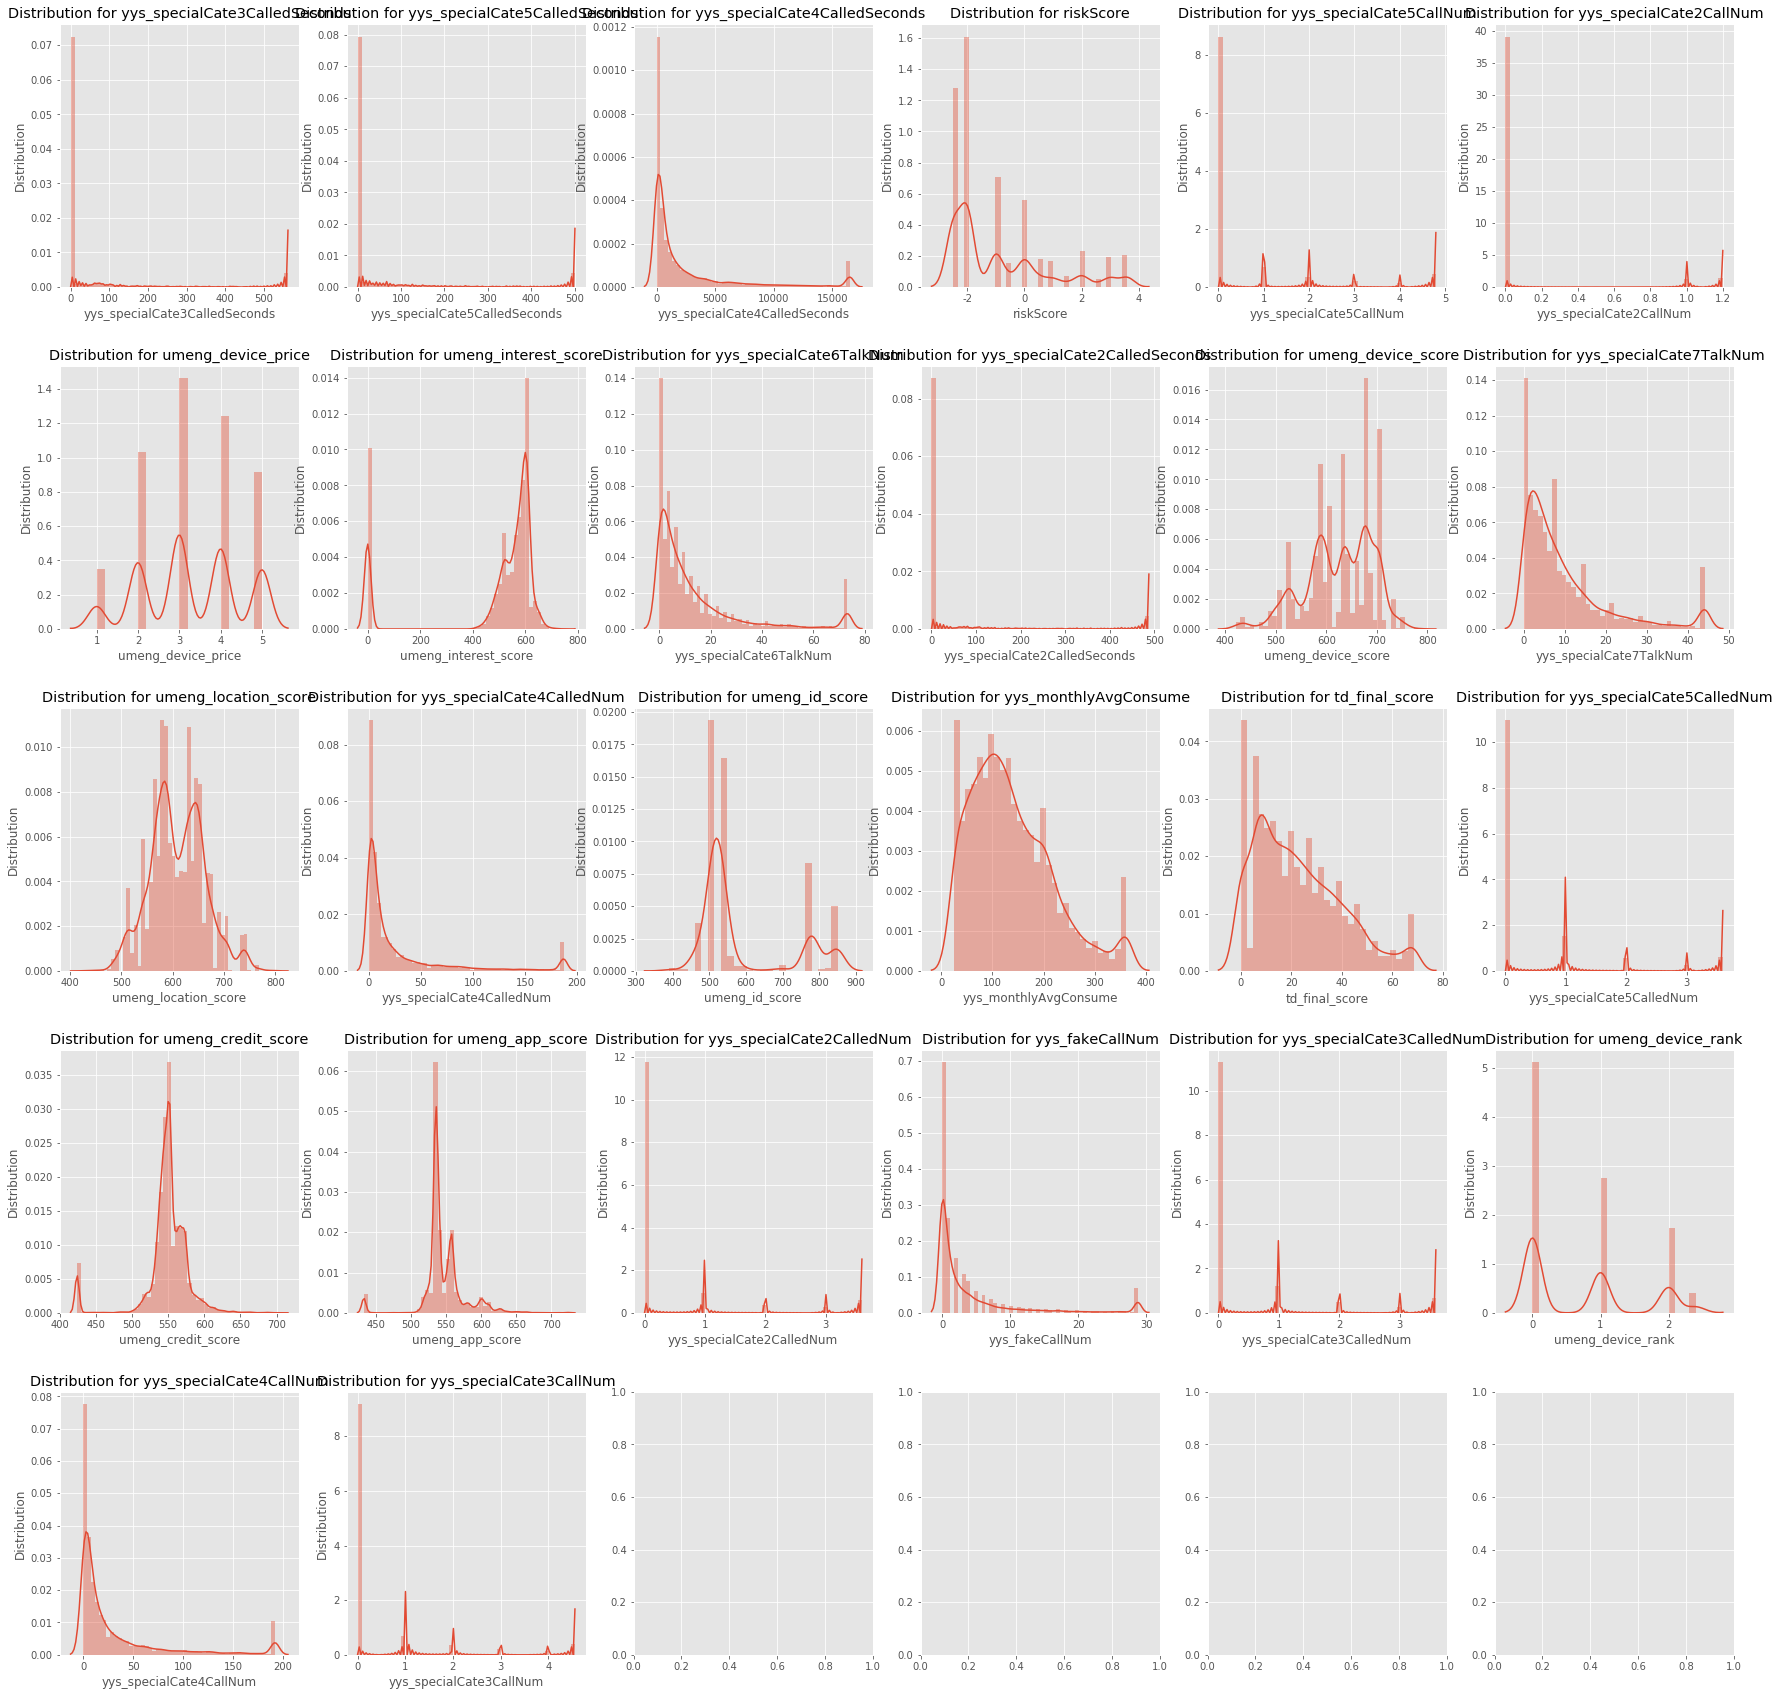

In [10]:
# plot historgrams for all original numerical variables # （画直方图）
#--------------------------------------------------------------------------------------------------#
plot_hist_all(df, target=target, exclude_list=exclude_list, extr_outlier_removed=True)


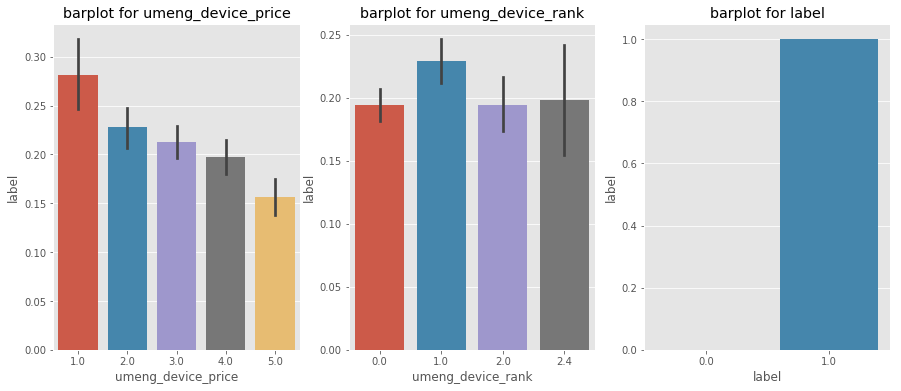

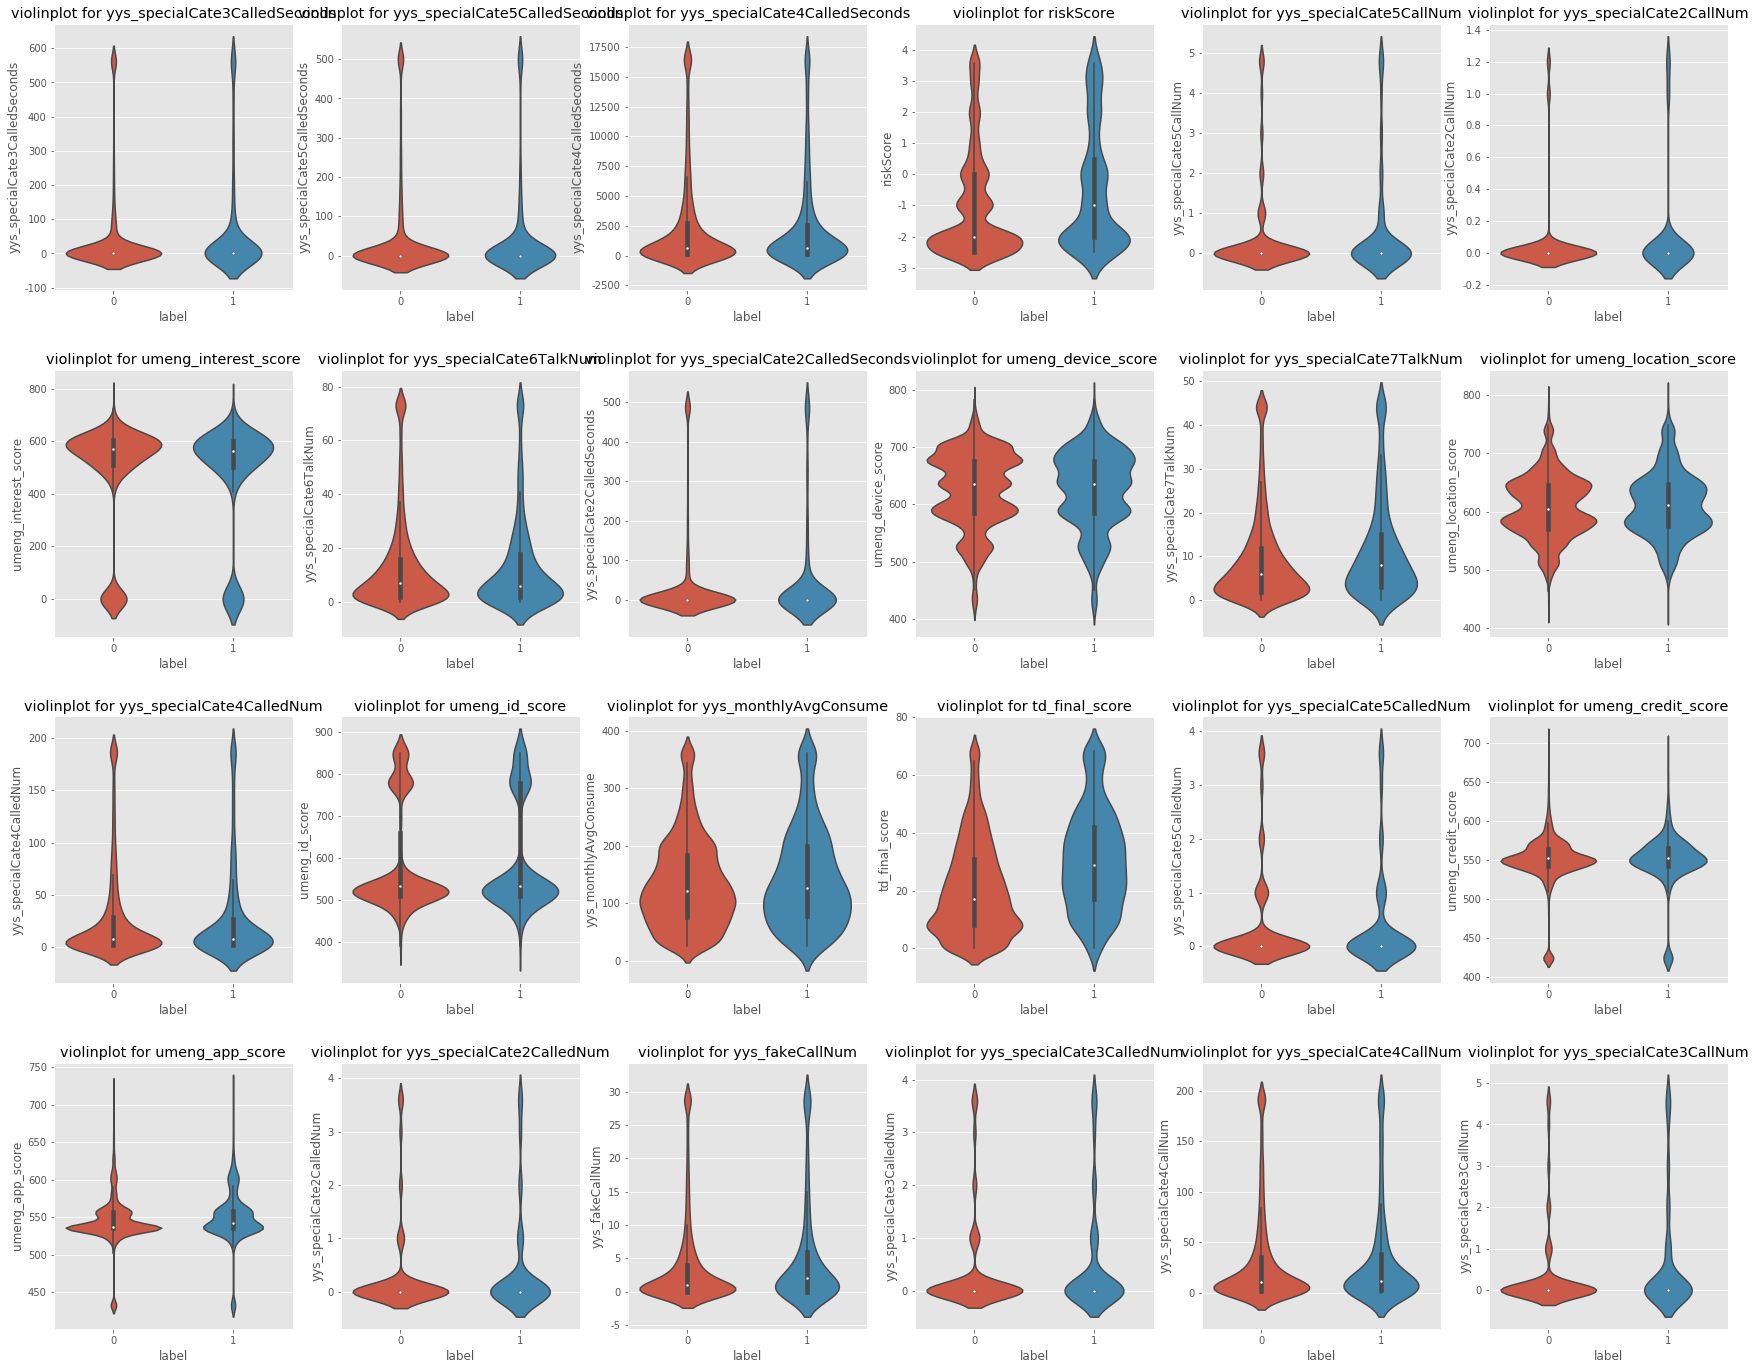

In [11]:
# plot barplot for categorical variables and violinplot for continuous variables # （画各个特征和标签的联合分布图）

#--------------------------------------------------------------------------------------------------#
plot_joint_dist_all(df, label=label, target=target, exclude_list=exclude_list, nunique_thr=10, extr_outlier_removed=True)


## SAMPLE_SPLITTER

In [12]:
# df_ol is used to test recoding statements and can be regarded as the online data # （留出几个样本当成线上样本检验python特征工程代码）
df_ol = df.iloc[:2]


In [13]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################   4. SAMPLE SPLITTER   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

#     Split samples into two or three sets: train, validation (and oot(test)) sets.
#     oot(test) set contains lastest samples # （样本切分（训练集、验证集——随机切分、测试集——OOT））
#--------------------------------------------------------------------------------------------------#
df_tr, df_va, df_te = sample_splitter(df, label=None, dt_col=dt_col, val_size=0.2, test_size=0.1, split_by_ratio=True,
                                      method='oot', dt_format='%Y-%m-%d', drop_dt_col=False, random_state=7)


train set ranges from 2018-04-28 00:00:00 to 2018-08-13 00:00:00
test set ranges from 2018-08-13 00:00:00 to 2018-10-25 00:00:00



In [14]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################   WRITE OUTPUT FILES   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################
# intialize recoding statement dictionary and feature dictionary which records changes of feature names
rs = GenerateOutputFiles(df, label, target=target, exclude_list=exclude_list)

#--------------------------------------------------------------------------------------------------#
# generate woe recoding profile
rs.generate_lr_recoding_dict(lr_recoding_file)
feat_stat = rs.write_statistical_summary(feature_stat_file, encoding="utf-8");feat_stat # （特征统计数据）
woe_stat = rs.woe_recoding_stat(woe_recoding_stat_file, encoding="utf-8");woe_stat # （特征WOE编码统计数据）


,count,mean,std,min,1%,25%,50%,75%,99%,max,missing_cnt,missing_rate,coverage_count,coverage_rate,unique_value_cnt,HF_value,HF_value_cnt,HF_value_pct,iv
yys_specialCate3CalledSeconds,6745,93.97,460.83,0.00,0.00,0.00,0.00,0.00,2009.08,11599.00,2706,28.63%,6745,71.37%,619,0,5475,57.93%,0.081798
yys_specialCate5CalledSeconds,6745,107.46,791.43,0.00,0.00,0.00,0.00,0.00,2053.28,37542.00,2706,28.63%,6745,71.37%,621,0,5314,56.23%,0.068471
yys_specialCate4CalledSeconds,6745,2998.58,7095.92,0.00,0.00,120.00,657.00,2672.00,33368.12,198710.00,2706,28.63%,6745,71.37%,3287,0,804,8.51%,0.084297
riskScore,9451,-1.00,1.97,-3.00,-3.00,-2.00,-2.00,0.00,5.00,10.00,0,0.00%,9451,100.00%,23,-2,2813,29.76%,0.117857
yys_specialCate5CallNum,6745,1.28,11.55,0.00,0.00,0.00,0.00,0.00,21.00,574.00,2706,28.63%,6745,71.37%,67,0,5584,59.08%,0.069041
yys_specialCate2CallNum,6745,0.31,3.69,0.00,0.00,0.00,0.00,0.00,6.00,203.00,2706,28.63%,6745,71.37%,35,0,6330,66.98%,0.081329
umeng_device_price,7405,3.27,1.18,1.00,1.00,2.00,3.00,4.00,5.00,5.00,2046,21.65%,7405,78.35%,5,3,2164,22.90%,0.029043
umeng_interest_score,7561,483.22,209.08,-1.00,-1.00,507.00,568.00,604.00,657.00,762.00,1890,20.00%,7561,80.00%,269,-1,1146,12.13%,0.027979
yys_specialCate6TalkNum,6745,17.69,49.76,0.00,0.00,2.00,7.00,16.00,205.68,1339.00,2706,28.63%,6745,71.37%,219,0,876,9.27%,0.078879
yys_specialCate2CalledSeconds,6745,87.54,513.48,0.00,0.00,0.00,0.00,0.00,1902.16,21752.00,2706,28.63%,6745,71.37%,582,0,5704,60.35%,0.078084


,feature,iv,woe,group,depvar_count,depvar_rate,count,count_proportion,lift,max,min
0,td_final_score,0.388113,-1.37554,"(-inf, 5.5]",71,6.23%,1140,12.06%,29.9245,5,0
0,td_final_score,0.388113,-0.871284,"(5.5, 7.5]",75,9.91%,757,8.01%,47.6035,7,6
0,td_final_score,0.388113,-0.578309,"(7.5, 10.5]",125,12.85%,973,10.30%,61.7263,10,8
0,td_final_score,0.388113,-0.268095,"(10.5, 18.5]",276,16.74%,1649,17.45%,80.4196,18,11
0,td_final_score,0.388113,0.0587149,"(18.5, 25.5]",279,21.80%,1280,13.54%,104.729,25,19
0,td_final_score,0.388113,0.235577,"(25.5, 29.5]",161,24.96%,645,6.82%,119.933,29,26
0,td_final_score,0.388113,0.375734,"(29.5, 34.5]",199,27.68%,719,7.61%,132.983,34,30
0,td_final_score,0.388113,0.556099,"(34.5, 42.5]",297,31.43%,945,10.00%,151.007,42,35
0,td_final_score,0.388113,0.674418,"(42.5, 56.5]",292,34.03%,858,9.08%,163.519,56,43
0,td_final_score,0.388113,0.913581,"(56.5, inf]",192,39.59%,485,5.13%,190.21,79,57


## FEATURE TRANSFORMATION

In [15]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################5. FEATURE TRANSFORMATION#####################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Find the best transformation for each feature in the input dataframe（特征变换（对数、平方、开方））
#--------------------------------------------------------------------------------------------------#
basic_transformr = FeatureTransformer(target=target, drop_features=True, silent=False, recoding_dict=rs.recoding_dict, feat_dict=rs.feat_dict)
#--------------------------------------------------------------------------------------------------#
df_tr = basic_transformr.fit_transform(df_tr, label=label, action=useTransformr, exclude_list=exclude_list)
df_va = basic_transformr.transform(df_va, label=label, action=useTransformr, exclude_list=exclude_list)
df_te = basic_transformr.transform(df_te, label=label, action=useTransformr, exclude_list=exclude_list)


Best transformation for yys_specialCate3CalledSeconds is square transformation
Best transformation for yys_specialCate5CalledSeconds is log transformation
Best transformation for yys_specialCate4CalledSeconds is log transformation
Best transformation for riskScore is square transformation
Best transformation for yys_specialCate5CallNum is square transformation
Best transformation for yys_specialCate2CallNum is square transformation
Best transformation for umeng_device_price is log transformation
Best transformation for umeng_interest_score is log transformation
Best transformation for yys_specialCate6TalkNum is sqrt transformation
Best transformation for yys_specialCate2CalledSeconds is without transformation
Best transformation for umeng_device_score is square transformation
Best transformation for yys_specialCate7TalkNum is square transformation
Best transformation for umeng_location_score is log transformation
Best transformation for yys_specialCate4CalledNum is log transformation
B

## FEATURE TRIMMING

In [16]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################  6. FEATURE TRIMMING   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Trim continuous variables in the dataframe（特征修剪——去掉极端值）
#--------------------------------------------------------------------------------------------------#
trimmr = FeatureTrimmer(target=target, silent=False, recoding_dict=rs.recoding_dict, feat_dict=rs.feat_dict)
#--------------------------------------------------------------------------------------------------#
df_tr = trimmr.fit_transform(df_tr, label=label, action=useTrimmr, exclude_list=exclude_list)
df_va = trimmr.transform(df_va, label=label, action=useTrimmr, exclude_list=exclude_list)
df_te = trimmr.transform(df_te, label=label, action=useTrimmr, exclude_list=exclude_list)


Lower bound of umeng_interest_score_log is -11.512900 while its upper bound is 6.635900
Lower bound of yys_monthlyAvgConsume_log is 1.167000 while its upper bound is 8.180700
Lower bound of yys_specialCate3CalledSeconds_square is 0.000000 while its upper bound is 5842334.940000
Lower bound of yys_specialCate3CallNum_square is 0.000000 while its upper bound is 183.915000
Lower bound of umeng_app_score_log is -11.512900 while its upper bound is 6.618700
Lower bound of yys_specialCate5CalledNum_log is -11.512900 while its upper bound is 6.068400
Lower bound of umeng_device_score_square is 146689.000000 while its upper bound is 611524.000000
Lower bound of yys_specialCate3CalledNum_square is 0.000000 while its upper bound is 150.000000
Lower bound of yys_specialCate2CalledNum is 0.000000 while its upper bound is 13.500000
Lower bound of yys_specialCate5CalledSeconds_log is -11.512900 while its upper bound is 10.051400
Lower bound of yys_fakeCallNum_square is 0.000000 while its upper bound 

## FEATURE ENCODING

In [17]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################   7. FEATURE ENCODING  ######################################
######################################                        ######################################
####################################################################################################

# Try to recode each feature in the dataframe（对特征进行编码，可默认选择WOE或者手工选择编码方式）
#--------------------------------------------------------------------------------------------------#
# detect features of type object（查看object特征）
df_tr.select_dtypes(include=[object]).head()


,docid,td_final_decision,baidu_risk_blacklevel,umeng_device_os,yys_friendMap,yys_phoneLocation,geo_A3_RSL,geo_B7_RSL
3922,41108119890130037X,Review,NaN,android,河南,河南,"\3\""""","\0\"""""
10069,211022197308126882,Accept,NaN,NaN,辽宁,辽宁,"\2\""""","\1\"""""
8815,230125198110013534,Review,NaN,android,黑龙江,黑龙江,"\2\""""","\0\"""""
3064,220183198511275676,Accept,NaN,NaN,吉林,吉林,"\04\""""","\0\"""""
10622,522401199408080298,Review,NaN,android,贵州,贵州,"\2\""""","\0\"""""


In [18]:
encodr = FeatureEncoder(target=target, use_woe_encoder=useWoeEncoder, drop_features=True,
                        we_cut_method='qcut', be_cut_method='qcut', recoding_dict=rs.recoding_dict, feat_dict=rs.feat_dict)
#--------------------------------------------------------------------------------------------------#
df_tr = encodr.fit_transform(df_tr, label
                            , WoeEncoder_feat=[
                                               'yys_fakeCallNum_square'
                                              ,'yys_specialCate3CalledNum_square'
                                              ,'yys_specialCate5CalledNum_log'
                                              ,'yys_specialCate4CalledSeconds_log'
                                              , 'yys_specialCate5CalledSeconds_log'
                                              , 'yys_specialCate3CallNum_square'
                                              , 'yys_specialCate4CalledNum_log']
                            , BinEncoder_feat=[
                                               'umeng_credit_score_sqrt'
                                              ,'umeng_device_price_log'
                                              ,'umeng_device_score_square'
                                              ,'umeng_id_score_square'
                                              ,'umeng_interest_score_log'
                                              ,'umeng_location_score_log']
                            , CountEncoder_feat=[
                                               'td_final_score_log']
                            , OneHotEncoder_feat=[
                                                'td_final_decision']
                            , TargetEncoder_feat=[
                                                 'yys_friendMap']
                            , NaEncoder_feat=[
                                            'geo_B7_RSL']
                            , exclude_list=exclude_list)

df_va = encodr.transform(df_va, label, exclude_list=exclude_list)
df_te = encodr.transform(df_te, label, exclude_list=exclude_list)


Apply WoeEncoder to encode geo_A3_RSL
Apply WoeEncoder to encode yys_specialCate7TalkNum_square
Apply WoeEncoder to encode umeng_app_score_log
Apply WoeEncoder to encode yys_specialCate2CalledSeconds
Apply WoeEncoder to encode yys_phoneLocation
Apply WoeEncoder to encode umeng_device_rank_square
Apply WoeEncoder to encode yys_monthlyAvgConsume_log
Apply WoeEncoder to encode yys_specialCate6TalkNum_sqrt
Apply WoeEncoder to encode riskScore_square
Apply WoeEncoder to encode yys_specialCate2CalledNum
Apply WoeEncoder to encode yys_specialCate3CalledSeconds_square
Apply WoeEncoder to encode yys_specialCate2CallNum_square
Apply WoeEncoder to encode yys_specialCate5CallNum_square
Apply WoeEncoder to encode umeng_device_os
Apply WoeEncoder to encode yys_specialCate4CallNum
Apply WoeEncoder to encode baidu_risk_blacklevel
Apply WoeEncoder to encode yys_fakeCallNum_square
Apply WoeEncoder to encode yys_specialCate3CalledNum_square
Apply WoeEncoder to encode yys_specialCate5CalledNum_log
Apply W

## FEATURE IMPUTATION

In [19]:
####################################################################################################
####################################################################################################
######################################                        ######################################
###################################### 8. FEATURE IMPUTATION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Imputes features seperately using defined imputation strategy（特征填补，默认选择均值填补，可手工选择填补方式）
#--------------------------------------------------------------------------------------------------#
# detect features with missing values #（查看当前特征缺失情况）
tmp = pd.concat([df_tr, df_va, df_te]).isnull().sum()
tmp[tmp != 0]


umeng_interest_score_log_be     1890
umeng_device_score_square_be    1287
umeng_device_price_log_be       2046
umeng_id_score_square_be        1042
umeng_location_score_log_be     1259
umeng_credit_score_sqrt_be      1099
dtype: int64

In [20]:
imputr = FeatureImputer(use_mean_method=True, target=target, silent=False, recoding_dict=rs.recoding_dict, feat_dict=rs.feat_dict)
#--------------------------------------------------------------------------------------------------#
df_tr = imputr.fit_transform(df_tr, label, action=useImputr,
                             mean_list=[],
                             median_list=[],
                             most_freq_list=[],
                             exclude_list=exclude_list)

df_va = imputr.transform(df_va, label, action=useImputr, exclude_list=exclude_list)
df_te = imputr.transform(df_te, label, action=useImputr, exclude_list=exclude_list)


Apply 'mean' method to impute umeng_device_score_square_be
Apply 'mean' method to impute umeng_interest_score_log_be
Apply 'mean' method to impute umeng_device_price_log_be
Apply 'mean' method to impute umeng_id_score_square_be
Apply 'mean' method to impute umeng_credit_score_sqrt_be
Apply 'mean' method to impute umeng_location_score_log_be


## FEATURE SCALING

In [21]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################   9. FEATURE SCALING   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Scaler features in the dataframe（特征标准变化选择）
#--------------------------------------------------------------------------------------------------#
scalr = FeatureScaler(target=target, silent=False, scaler_type='StandardScaler', recoding_dict=rs.recoding_dict, feat_dict=rs.feat_dict)
#--------------------------------------------------------------------------------------------------#
df_tr = scalr.fit_transform(df_tr, label=label, action=useScalr, exclude_list=exclude_list+encodr.final_OneHotEncoder_new_feat)
df_va = scalr.transform(df_va, label=label, action=useScalr, exclude_list=exclude_list+encodr.final_OneHotEncoder_new_feat)
df_te = scalr.transform(df_te, label=label, action=useScalr, exclude_list=exclude_list+encodr.final_OneHotEncoder_new_feat)


Apply StandardScaler to scale features


## OUTPUT RECODING STATEMENT

In [22]:
rs.write_recoding_txt(file_name=ud_recoding_file, encoding = "utf-8" ) # （输出特征工程python可执行代码，并用“线上数据”测试）

# recoding online data using the output recoding statement
df_ol = rs.exec_recoding(df_ol)
df_ol.head()


,docid,riskScore,loan_date,td_final_score,td_final_decision,baidu_risk_blacklevel,umeng_credit_score,umeng_device_price,umeng_device_score,umeng_device_os,umeng_device_rank,umeng_id_score,umeng_interest_score,umeng_location_score,umeng_app_score,yys_fakeCallNum,yys_monthlyAvgConsume,yys_specialCate3CallNum,yys_specialCate3CalledNum,yys_specialCate3CalledSeconds,yys_specialCate2CallNum,yys_specialCate2CalledNum,yys_specialCate2CalledSeconds,yys_specialCate5CallNum,yys_specialCate5CalledNum,yys_specialCate5CalledSeconds,yys_specialCate7TalkNum,yys_specialCate6TalkNum,yys_specialCate4CallNum,yys_specialCate4CalledNum,yys_specialCate4CalledSeconds,yys_friendMap,yys_phoneLocation,geo_A3_RSL,geo_B7_RSL,label,td_final_decision_we,yys_specialCate4CalledSeconds_log,yys_specialCate4CalledSeconds_log_we,yys_specialCate2CallNum_square,yys_specialCate2CallNum_square_we,umeng_device_price_square,umeng_device_price_square_we,umeng_interest_score_log,umeng_interest_score_log_we,umeng_device_os_we,baidu_risk_blacklevel_we,umeng_device_score_square,umeng_device_score_square_we,yys_specialCate7TalkNum_square,yys_specialCate7TalkNum_square_we,umeng_location_score_log,umeng_location_score_log_we,yys_phoneLocation_we,td_final_score_log,td_final_score_log_we,yys_specialCate2CalledNum_square,yys_specialCate2CalledNum_square_we,yys_specialCate3CalledNum_square,yys_specialCate3CalledNum_square_we,yys_friendMap_we,yys_specialCate3CalledSeconds_square,yys_specialCate3CalledSeconds_square_we,yys_specialCate5CalledSeconds_log,yys_specialCate5CalledSeconds_log_we,riskScore_square,riskScore_square_we,yys_specialCate5CallNum_square,yys_specialCate5CallNum_square_we,yys_specialCate6TalkNum_we,yys_specialCate2CalledSeconds_square,yys_specialCate2CalledSeconds_square_we,geo_A3_RSL_we,yys_specialCate4CalledNum_log,yys_specialCate4CalledNum_log_we,umeng_id_score_square,umeng_id_score_square_we,yys_monthlyAvgConsume_log,yys_monthlyAvgConsume_log_we,yys_specialCate5CalledNum_square,yys_specialCate5CalledNum_square_we,umeng_credit_score_square,umeng_credit_score_square_we,umeng_app_score_log,umeng_app_score_log_we,yys_fakeCallNum_square,yys_fakeCallNum_square_we,umeng_device_rank_square,umeng_device_rank_square_we,geo_B7_RSL_we,yys_specialCate4CallNum_sqrt,yys_specialCate4CallNum_sqrt_we,yys_specialCate3CallNum_square,yys_specialCate3CallNum_square_we,td_final_decision_Review,td_final_decision_Accept,td_final_decision_<UNSEEN>*,umeng_device_price_log,umeng_device_price_log_be,umeng_interest_score_log_be,umeng_device_score_square_be,umeng_location_score_log_be,td_final_score_log_ce,yys_specialCate2CalledNum_we,yys_friendMap_te,yys_specialCate6TalkNum_sqrt,yys_specialCate6TalkNum_sqrt_we,yys_specialCate2CalledSeconds_we,umeng_id_score_square_be,yys_specialCate5CalledNum_log,yys_specialCate5CalledNum_log_we,umeng_credit_score_sqrt,umeng_credit_score_sqrt_be,geo_B7_RSL_ne,yys_specialCate4CallNum_we
0,413024198009031011,-3.0,2018-05-24,18,Accept,<NA>*,547.0,5.0,656.0,ios,0.0,510.0,566.0,578.0,535.0,0.0,166.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,8.0,1455.0,河南,河南,"\3\""""","\0\""""",0,-0.616782,7.282761,-0.006329,0.0,-0.156570,25.0,-0.352061,6.338594,0.089501,-0.258579,-0.044268,430336.0,-0.074562,0.0,-0.353161,6.359574,0.087997,-0.213296,2.890372,-0.126777,0.0,-0.209333,0.0,-0.174982,-0.355418,0.0,-0.196204,-11.5129,-0.161734,9.0,0.314438,0.0,-0.184721,-0.298316,0.0,-0.219596,-0.100371,2.079442,0.078023,260100.0,-0.016101,5.117035,-0.267741,0.0,-0.176734,299209.0,-0.240131,6.282267,-0.328025,0.0,-0.290137,0.0,-0.011172,0.022847,1.0,-0.283914,0.0,-0.217743,0,1,0,1.609400,3.0,3.0,6.0,2.0,178,-0.187763,0.169161,3.0,-0.359686,-0.191451,1.0,-11.5129,-0.165514,23.388031,4.0,0,-0.214140
1,230404198009040524,-2.0,2018-07-02,6,Accept,<NA>*,577.0,3.0,681.0,android,0.0,532.0,611.0,588.0,535.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>*,<NA>*,"\3\""""","\0\""""",0,-0.616782,NaN,0.294114,NaN,0.294114,9.0,-0.064357,6.415097,-0.239003,0.099944,-0.044

## FEATURE SELECTION

In [23]:
####################################################################################################
####################################################################################################
######################################                        ######################################
###################################### 10. FEATURE SELECTION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

ffiltr = FeatureFilter(target=target, exclude_list=exclude_list, silent=False)
#--------------------------------------------------------------------------------------------------#
if useIvFiltr: # （使用IV进行特征筛选）
    print_stype_line();
    print('IV FILTER IS FILTERING FEATURES');
    print_stype_line()

    df_tr = ffiltr.iv_filter_fit_transform(df_tr, label, drop_suspicous=True, cov_appd_list=[], cav_appd_list=[], iv_floor=0.02, iv_cap=1,
                                              trimmr=None, bins=10, woe_min=-20, woe_max=20)
    df_va = ffiltr.iv_filter_transform(df_va)
    df_te = ffiltr.iv_filter_transform(df_te)
    df_ol = ffiltr.iv_filter_transform(df_ol)
#--------------------------------------------------------------------------------------------------#
if useXgbfiFiltr: # （使用XGB模型的特征重要性进行特征筛选）
    print_stype_line();
    print('FEATURE IMPORTANCE FILTER BASED ON XGBOOST MODEL IS FILTERING FEATURES');
    print_stype_line()

    df_tr = ffiltr.xgbFI_filter_fit_transform(df_tr, label, None, xgb_params=XGB_PARAMS, alpha=0.7, top=xgb_feat_cnt,
                                                 random_state=2019)
    df_va = ffiltr.xgbFI_filter_transform(df_va, label)
    df_te = ffiltr.xgbFI_filter_transform(df_te, label)
    df_ol = ffiltr.xgbFI_filter_transform(df_ol, label)
    ffiltr.xgb_fi.head(20)
#--------------------------------------------------------------------------------------------------#
if useRFfiFiltr: # （使用随机森林模型的特征重要性进行特征筛选）
    print_stype_line();
    print('FEATURE IMPORTANCE FILTER BASED ON RANDOMFOREST MODEL IS FILTERING FEATURES');
    print_stype_line()

    df_tr = ffiltr.rfFI_filter_fit_transform(df_tr, label, top=rf_feat_cnt)
    df_va = ffiltr.rfFI_filter_transform(df_va, label)
    df_te = ffiltr.rfFI_filter_transform(df_te, label)
    df_ol = ffiltr.rfFI_filter_transform(df_ol, label)
    ffiltr.rf_fi.head(15)
#--------------------------------------------------------------------------------------------------#
if useLRFiltr: # （使用逻辑回归逐步回归法进行特征筛选）
    print_stype_line();
    print('FEATURE IMPORTANCE FILTER BASED ON LOGISTIC REGRESSION MODEL IS FILTERING FEATURES');
    print_stype_line()
      
    df_tr = ffiltr.lr_filter_fit_transform(df_tr, label, score_based=True, bidirectional=True, standard='bic',
                                           feat_cnt=lr_feat_cnt, alpha=0.05)
    df_va = ffiltr.lr_filter_transform(df_va, label)
    df_te = ffiltr.lr_filter_transform(df_te, label)
    df_ol = ffiltr.lr_filter_transform(df_ol, label)
#--------------------------------------------------------------------------------------------------#
if useCorVifFiltr: # （使用相关系数和膨胀系数进行特征筛选）
    print_stype_line();
    print('FEATURE FILTER BASED ON CORRELATION MATRIX AND VIF IS FILTERING FEATURES');
    print_stype_line()

    df_tr = ffiltr.cor_vif_filter_fit_transform(df_tr, label, cor_thr=0.95, vif_thr=10)
    df_va = ffiltr.cor_vif_filter_transform(df_va, label)
    df_te = ffiltr.cor_vif_filter_transform(df_te, label)
    df_ol = ffiltr.cor_vif_filter_transform(df_ol, label)



########################################################################################################################
########################################################################################################################

IV FILTER IS FILTERING FEATURES

########################################################################################################################
########################################################################################################################

Features shown as below should be dropped

                              iv_for_label
umeng_interest_score_log_be          0.019
riskScore_square_we                  0.019
umeng_device_score_square_be         0.011
umeng_id_score_square_be             0.007
umeng_device_rank_square_we          0.002
geo_B7_RSL_ne                        0.000

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

These feature

,weight,weight_rank,gain,gain_rank,rank
td_final_score_log_ce,394,1,21.754008,3,2.4
yys_friendMap_te,277,2,16.282829,5,4.1
td_final_decision_Review_oe,115,13,73.630228,1,4.6
yys_phoneLocation_we,155,8,18.053518,4,5.2
yys_specialCate7TalkNum_square_we,168,6,14.225256,7,6.7
umeng_app_score_log_we,172,5,13.728540,8,7.1
td_final_decision_Accept_oe,56,20,69.625584,2,7.4
umeng_device_os_we,115,12,14.855121,6,7.8
geo_A3_RSL_we,208,3,12.106966,10,7.9
umeng_device_price_log_be,136,9,12.377318,9,9.0



########################################################################################################################
########################################################################################################################

FEATURE IMPORTANCE FILTER BASED ON RANDOMFOREST MODEL IS FILTERING FEATURES

########################################################################################################################
########################################################################################################################

Features shown as are important according to RandomForest model's feature importance ranking



,feature importance
td_final_decision_Review_oe,0.284479
td_final_decision_Accept_oe,0.187247
td_final_score_log_ce,0.185600
yys_friendMap_te,0.072409
yys_phoneLocation_we,0.061596
yys_specialCate7TalkNum_square_we,0.038197
yys_specialCate3CallNum_square_we,0.030341
umeng_app_score_log_we,0.027032
yys_fakeCallNum_square_we,0.024107
geo_A3_RSL_we,0.012346



########################################################################################################################
########################################################################################################################

FEATURE IMPORTANCE FILTER BASED ON LOGISTIC REGRESSION MODEL IS FILTERING FEATURES

########################################################################################################################
########################################################################################################################

td_final_decision_Accept_oe removed: bic = 8522.438100
yys_phoneLocation_we removed: bic = 8643.037000
td_final_score_log_ce removed: bic = 6787.880300
umeng_device_price_log_be removed: bic = 6686.245100
geo_A3_RSL_we removed: bic = 6652.719100
umeng_app_score_log_we removed: bic = 6625.199200
yys_specialCate7TalkNum_square_we removed: bic = 6601.134300
yys_friendMap_te removed: bic = 6581.301200
yys_phoneLocation_we added: 

## FEATURE EVALUATION


########################################################################################################################
########################################################################################################################

FEATURE EXPLORATION MODULE IS PROCESSING

########################################################################################################################
########################################################################################################################

Correlation map of features


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  
Vif of features
                                     vif
loan_date                          1.225
td_final_decision_Accept_oe        1.000
yys_specialCate7TalkNum_square_we  1.000
td_final_score_log_ce              1.000
umeng_app_score_log_we             1.000
baidu_risk_blacklevel_we           1.000
geo_A3_RSL_we   

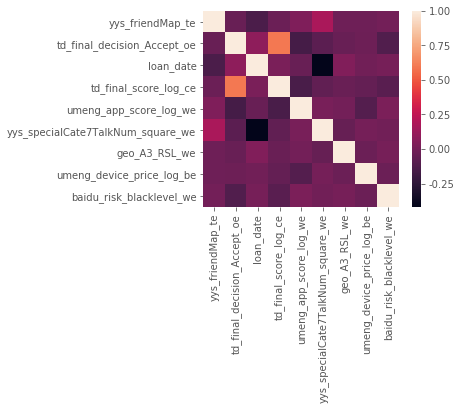

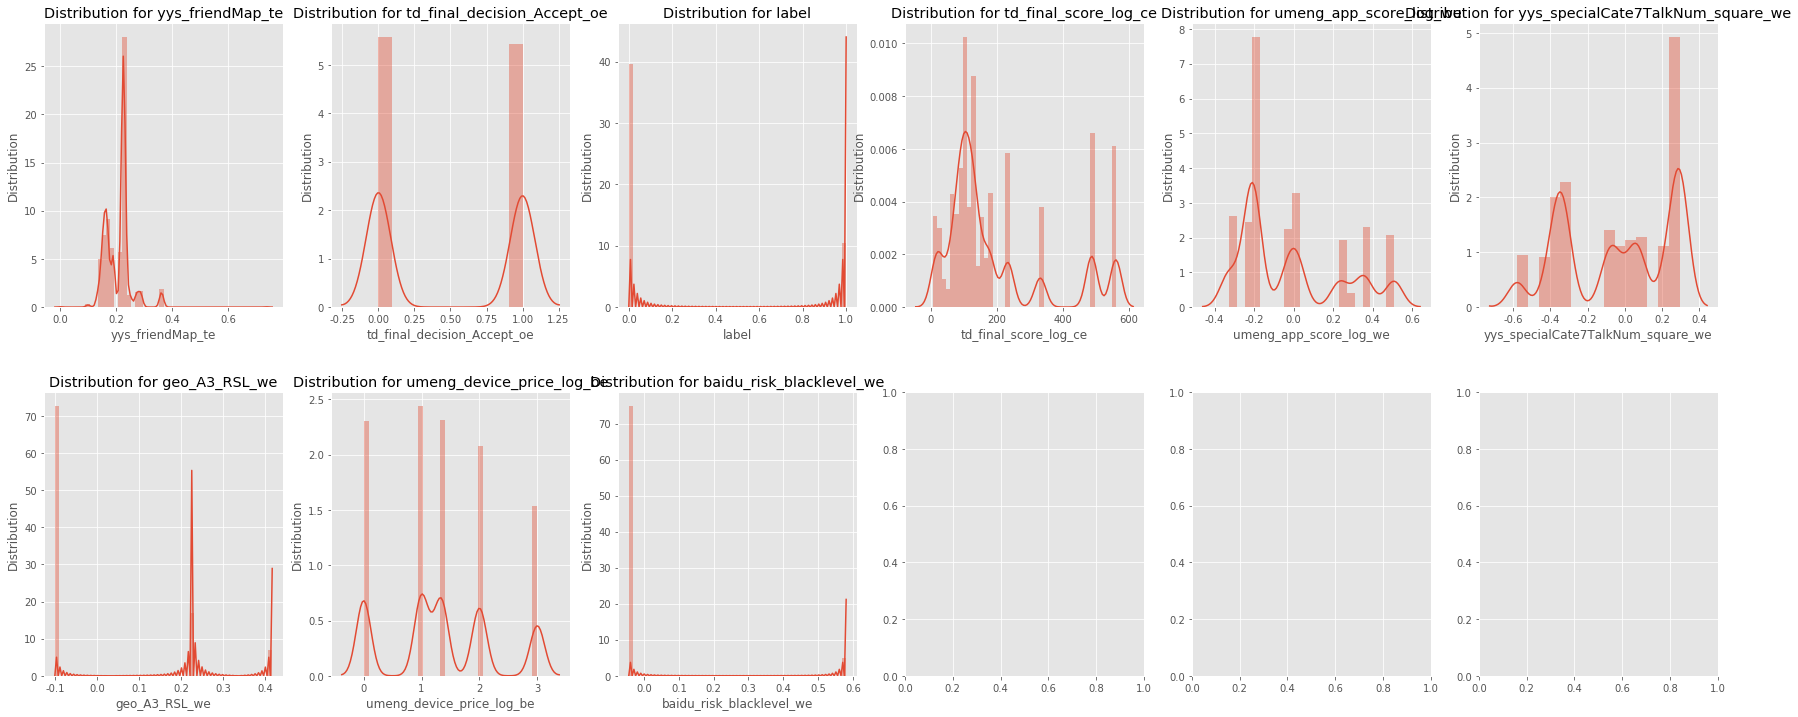

In [24]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################11. FEATURE EVALUATION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

print_stype_line();
print('FEATURE EXPLORATION MODULE IS PROCESSING');
print_stype_line()

# Calculate vifs and correlations of columns in the dataframe
df = pd.concat([df_tr, df_va, df_te], axis=0)
vif, _ = get_vif_cor(df, target, plot=True)

print('\n' + '_ ' * 60 + ' ');print("Vif of features");print(vif)
#--------------------------------------------------------------------------------------------------#
print('\n' + '_ ' * 60 + ' ');print("plot histograms of features")

plot_hist_all(df, exclude_list=exclude_list, extr_outlier_removed=False)


## MODEL TRAINING

In [25]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################   12. MODEL TRAINING   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################
# columns used to train models # （模型训练通过贝叶斯调参选取最优参数）
col = [i for i in df_tr.columns if i not in [label] + exclude_list + target]

x = pd.concat([df_tr[col], df_va[col], df_te[col]], axis=0)
y = pd.concat([df_tr[label], df_va[label], df_te[label]], axis=0)


In [26]:
print_stype_line();print('MODEL SELECTION MODULE IS PROCESSING');print_stype_line()
best_model, best_model_params, score_dict, params_dict = model_selection(x, y, init_points=5, n_iter=10, acq='ei', cv=5, clf_metric='auc', reg_metric='rmse', random_state=2019,
                                                                         model_list=['xgb', 'rf', 'ada', 'gb', 'et', 'ovr', 'knn', 'lr'])


########################################################################################################################
########################################################################################################################

MODEL SELECTION MODULE IS PROCESSING

########################################################################################################################
########################################################################################################################

Apply bayesian optimization to train XGBoost model

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   |  lambdA   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6979   |  9.858    |  0.7129   |  0.08252  |  0.7338   |  90.39    |  9.304    |  13.52    |  0.3849   |
|  2        |  0.6874   |  1.279    |  0.1144   |  0.2044

|  10       |  0.6973   |  0.9658   |  1e+03    |
|  11       |  0.6978   |  0.518    |  999.8    |
|  12       |  0.694    |  0.02201  |  722.1    |
|  13       |  0.6979   |  0.5204   |  999.8    |
|  14       |  0.6973   |  0.7224   |  999.9    |
|  15       |  0.6975   |  0.8552   |  999.8    |
Best combination of parameters are shownn as below
 {'base_estimator': None, 'n_estimators': 999, 'learning_rate': 0.5204157668135189, 'algorithm': 'SAMME.R'}

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

Apply bayesian optimization to train GBDT model

|   iter    |  target   | learni... | max_depth | min_im... | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.6488   |  0.7561   |  12.77    |  0.000427 |  0.01707  |  14.4     |  12.99    |  0.6595   |
|  2        |  0.6513   |  0.4203   |  

|  6        |  0.6881   |  1.0      |  0.1      |  0.01     |  2.0      |  392.7    |
|  7        |  0.6915   |  12.21    |  0.1552   |  0.05921  |  2.253    |  843.9    |
|  8        |  0.6829   |  40.0     |  0.1      |  0.07603  |  2.0      |  10.0     |
|  9        |  0.6878   |  1.0      |  0.1      |  0.01     |  2.0      |  504.6    |
|  10       |  0.6945   |  40.0     |  0.999    |  0.01     |  40.0     |  418.5    |
|  11       |  0.6877   |  1.0      |  0.1      |  0.01     |  2.0      |  799.5    |
|  12       |  0.667    |  39.84    |  0.6884   |  0.231    |  5.692    |  441.9    |
|  13       |  0.5      |  4.054    |  0.7021   |  0.3825   |  36.17    |  13.97    |
|  14       |  0.6959   |  40.0     |  0.1      |  0.01     |  40.0     |  300.9    |
|  15       |  0.6742   |  1.614    |  0.438    |  0.1356   |  2.012    |  840.1    |
Best combination of parameters are shownn as below
 {'n_jobs': -1, 'verbose': 0, 'criterion': 'gini', 'class_weight': 'balanced', 'n_estimat

In [27]:
# if best model is lr model, run this  # （逻辑回归模型参数）
LR_PARAMS = {'print':True, 'equation_file':lr_model_equation_file, 'model_summary_file':lr_model_summary_file, 'vif':vif}


In [28]:
# train lr model # （使用逻辑回归模型）
if model_linear:
    model, pred_train_value, pred_val_value, pred_test_value = model_toolkit('lr', df_tr[col], df_tr[label],
                                                                             x_val=df_va[col], y_val=df_va[label],
                                                                             x_test=df_te[col], xgb_params=None,
                                                                             make_prediction=True, **LR_PARAMS)


                                  Results: Logit
Model:                    Logit                 Pseudo R-squared:      0.083      
Dependent Variable:       label                 AIC:                   6491.8551  
Date:                     2020-05-14 13:27      BIC:                   6553.0289  
No. Observations:         6615                  Log-Likelihood:        -3236.9    
Df Model:                 8                     LL-Null:               -3531.4    
Df Residuals:             6606                  LLR p-value:           5.8130e-122
Converged:                1.0000                Scale:                 1.0000     
No. Iterations:           6.0000                                                  
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------
yys_friendMap_te                   5.3

In [29]:
# train the best model # （使用最优的模型）
model, pred_train_value, pred_val_value, pred_test_value = model_toolkit('xgb', df_tr[col], df_tr[label],
                                                                         x_val=df_va[col], y_val=df_va[label],
                                                                         x_test=df_te[col], xgb_params=XGB_PARAMS,
                                                                         make_prediction=True)


[0]	train-auc:0.647245	eval-auc:0.620838
[1]	train-auc:0.660703	eval-auc:0.630766
[2]	train-auc:0.669921	eval-auc:0.642251
[3]	train-auc:0.672272	eval-auc:0.64159
[4]	train-auc:0.675511	eval-auc:0.643517
[5]	train-auc:0.675589	eval-auc:0.642502
[6]	train-auc:0.675932	eval-auc:0.643004
[7]	train-auc:0.678659	eval-auc:0.647535
[8]	train-auc:0.678731	eval-auc:0.649003
[9]	train-auc:0.678596	eval-auc:0.647208
[10]	train-auc:0.679901	eval-auc:0.648238
[11]	train-auc:0.679975	eval-auc:0.650486
[12]	train-auc:0.680774	eval-auc:0.651471
[13]	train-auc:0.680356	eval-auc:0.651076
[14]	train-auc:0.680543	eval-auc:0.652073
[15]	train-auc:0.681825	eval-auc:0.652109
[16]	train-auc:0.682163	eval-auc:0.652583
[17]	train-auc:0.681482	eval-auc:0.652176
[18]	train-auc:0.681117	eval-auc:0.653093
[19]	train-auc:0.683441	eval-auc:0.653807
[20]	train-auc:0.684691	eval-auc:0.654656
[21]	train-auc:0.683864	eval-auc:0.653952
[22]	train-auc:0.683779	eval-auc:0.653758
[23]	train-auc:0.683461	eval-auc:0.653171
[24

In [30]:
# 做CV
with HiddenPrints():
    _, summary = cv_check(x[col], y, model_name='xgb', xgb_params=XGB_PARAMS, x_test=None, y_test=None,
                          cv=5, random_state=2019, silent=True)
summary


auc                ks           threshold           pass_rate  \
          mean       std    mean       std      mean       std      mean   
index                                                                      
train  0.69892  0.007852  0.3009  0.016931   0.55124  0.049091   0.61586   
val    0.69186  0.015794  0.3082  0.028015   0.54016  0.038439   0.64468   

                missing_negative_rate            
            std                  mean       std  
index                                            
train  0.043904               0.12762  0.004566  
val    0.098485               0.12772  0.019067

## MODEL EVALUATION

          auc      ks  threshold pass_rate missing_negative_rate
train  0.6952  0.2942     0.5889     59.9%                 14.0%
val    0.6609  0.2416     0.5487     49.6%                 13.6%
test   0.7080  0.3824     0.5095     52.3%                  2.2%
cutpoints derived from train set are  0, 0.41073469519615174, 0.45810750126838684, 0.49048912525177, 0.528795862197876, 0.5617431998252869, 0.5890943050384522, 0.6153530478477478, 0.6365634083747864, 0.6576153635978699, 1


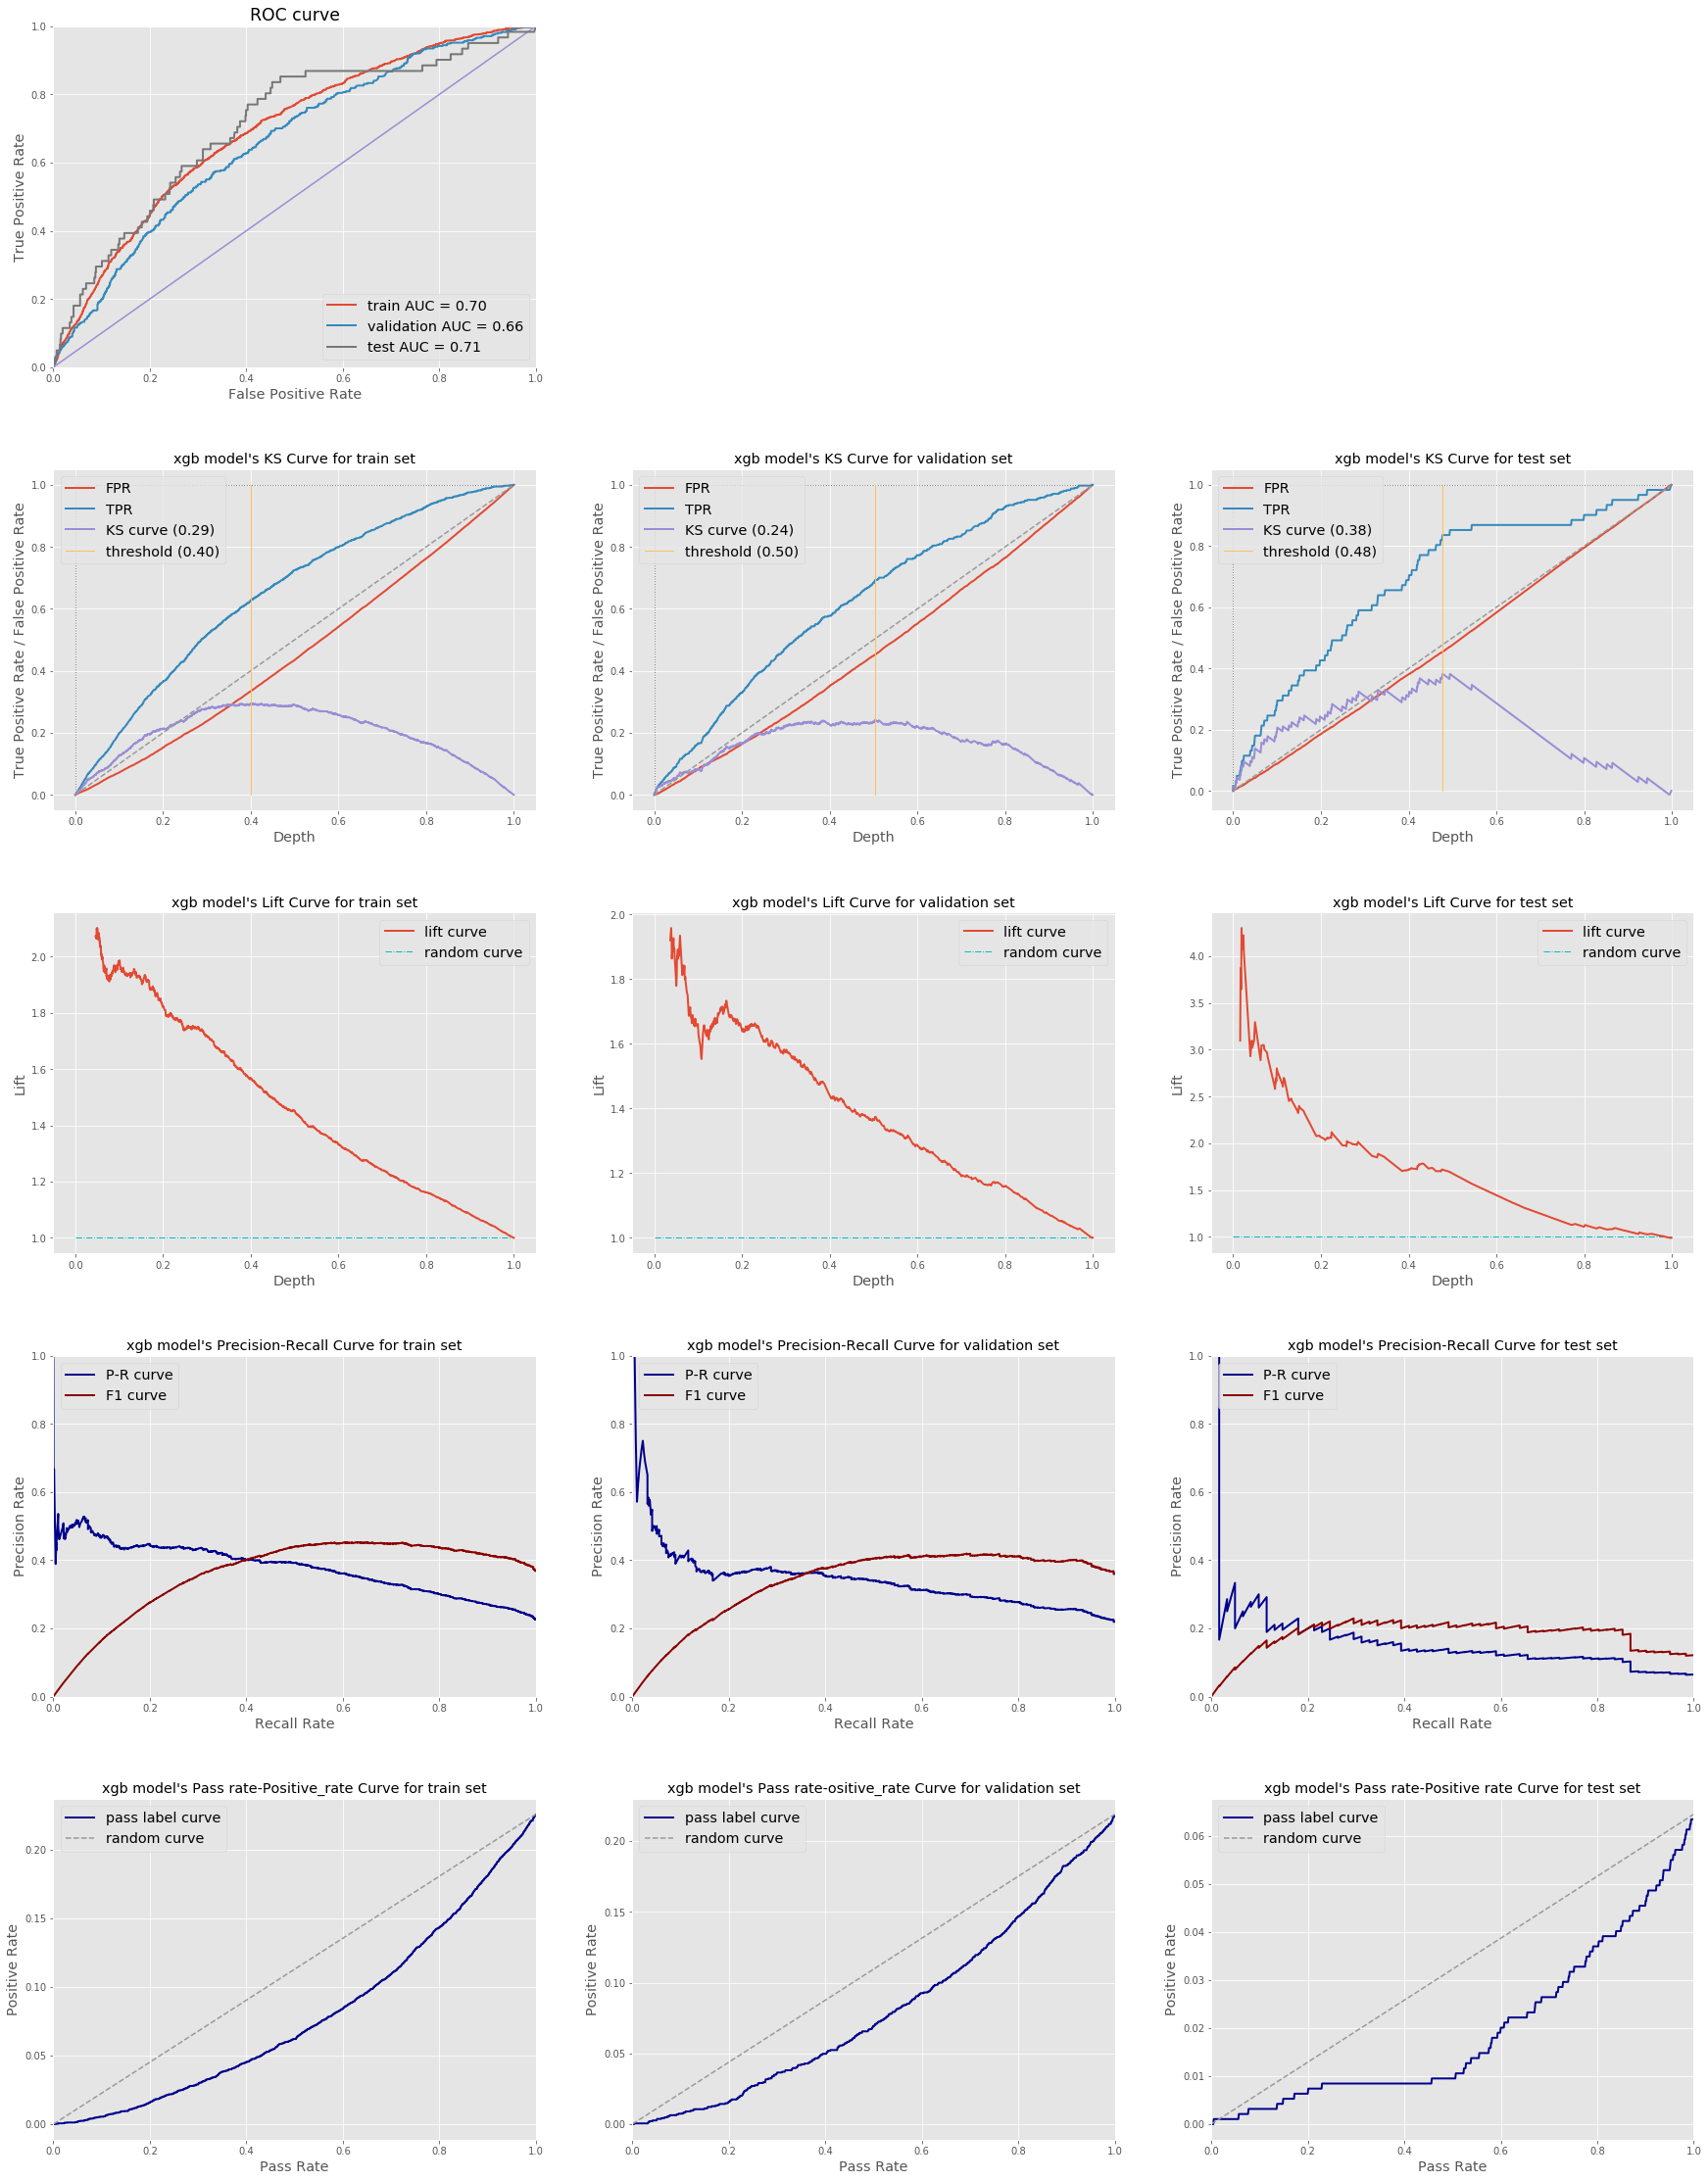

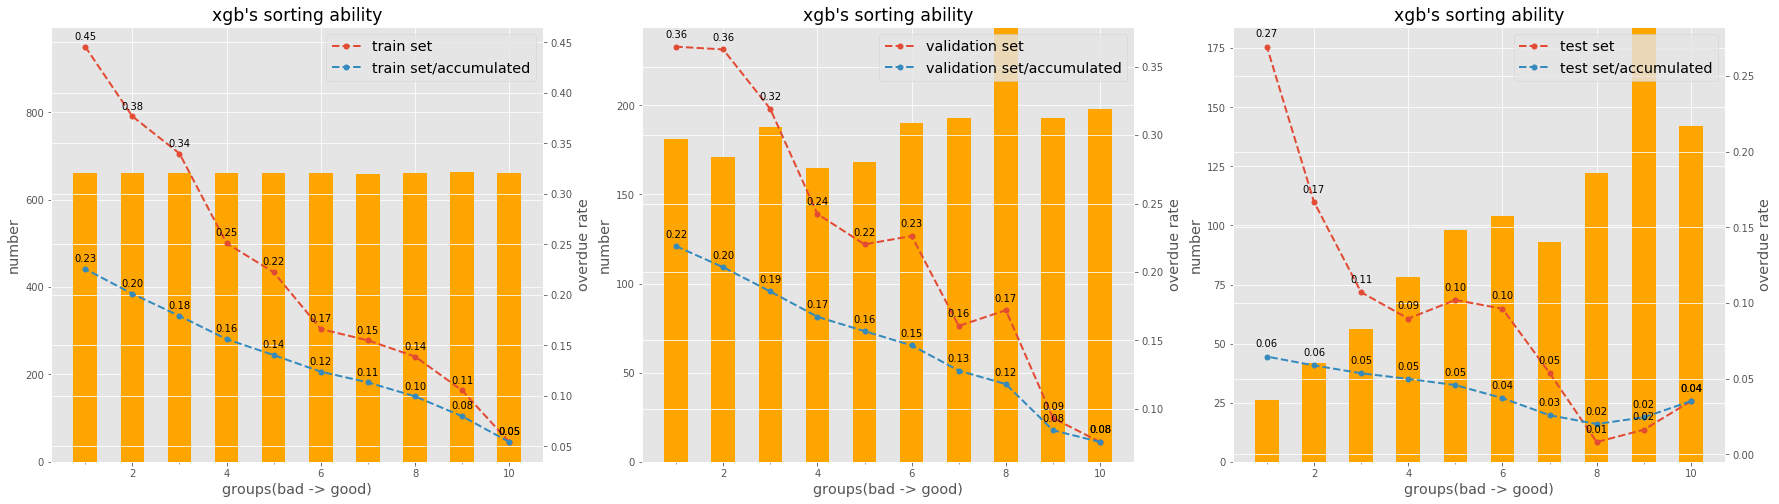

In [31]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################  13. MODEL EVALUATION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################
 # （模型指标统计及可视化）

tr, va, te = plot_all_figures(pred_train_value, df_tr[label], pred_val_value, df_va[label],
                              pred_test_value=pred_test_value,
                              real_test_label=df_te[label], pos_label=1)
